In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from file_process import process_genre_folder,add_tfidf_features,debug_tfidf_features
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from scipy.stats import t
import umap



c:\Users\Administrator\anaconda3\envs\lingu\lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\Administrator\anaconda3\envs\lingu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
chinese_path = "../data/chinese"  # ← Change to your folder path
english_path = "../data/english"

chinese_df = process_genre_folder(chinese_path,lang="ch")
english_df = process_genre_folder(english_path,lang="en")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache



Processing genre: history_fiction


Loading model cost 0.445 seconds.
Prefix dict has been built successfully.


  Success: 1. 长安十二时辰 (马伯庸) (Z-Library).txt                    → 237,443 words
  Success: 10. 历史的裂变：中国历史上的十三场政变（畅销书《大唐兴亡三百年》作者王觉仁力作，用小说笔法，讲述 → 143,503 words
  Success: 2. 风起陇西 (马伯庸 [马伯庸]) (Z-Library).txt                → 142,867 words
  Success: 3. 隋乱 (酒徒) (Z-Library).txt                         → 1,170,142 words
  Success: 4. 新宋 (阿越) (Z-Library).txt                         → 1,738,158 words
  Success: 5. 步步生莲 (月关) (Z-Library).txt                       → 1,790,461 words
  Success: 6. 宰执天下 (cuslaa) (Z-Library).txt                   → 3,852,110 words
  Success: 7. 窃明 (灰熊猫) (Z-Library).txt                        → 706,476 words
  Success: 8. 四时歌：骑桶人自选集 (骑桶人) (Z-Library).txt                → 149,371 words
  Success: 9. 辛亥：计划外革命 (雪珥) (Z-Library).txt                   → 85,673 words
  Success: 东宫.txt                                             → 134,227 words
  Success: 后宫：甄嬛传.txt                                         → 776,653 words
  Success: 将进酒-唐酒卿.txt                                   

In [21]:
chinese_df_idf = add_tfidf_features(chinese_df, base_path= chinese_path)

In [30]:
english_df_idf=add_tfidf_features(english_df, base_path= english_path)

In [32]:
#apply normalization
features = ["pronoun_ratio","info_density","avg_sent_len","tfidf_avg"]	
ch_no = chinese_df_idf[features].values
ch_no = (ch_no - ch_no.mean(axis=0)) / ch_no.std(axis=0)   # ← THIS IS THE NORMALIZATION
en_no = english_df_idf[features].values
en_no = (en_no - en_no.mean(axis=0)) / en_no.std(axis=0)   # ← THIS IS THE NORMALIZATION

In [33]:
pro_ch_df = chinese_df_idf.copy()
# Give normalized values back to df
for i, col in enumerate(features):
    pro_ch_df[f"{col}"] = ch_no[:, i]

In [34]:
pro_en_df = english_df_idf.copy()
# Give normalized values back to df
for i, col in enumerate(features):
    pro_en_df[f"{col}"] = en_no[:, i]

In [35]:
df = pd.concat([pro_en_df, pro_ch_df], ignore_index=True)

In [36]:
# pca_df = df.dropna(subset=["pronoun_ratio", "info_density", "avg_sent_len","tfidf_avg"]).reset_index(drop=True)

# Now PCA will work perfectly
pca_X = df[features]

In [37]:
pca_X

,pronoun_ratio,info_density,avg_sent_len,tfidf_avg
0,-1.600466,-0.924076,0.044852,-0.443909
1,-0.810758,-1.550994,1.928943,2.099346
2,1.141841,0.191181,0.517778,-0.019748
3,1.092357,-0.105854,0.214558,0.092094
4,-0.449635,-1.384388,0.523172,-0.788419
...,...,...,...,...
169,-0.005175,0.097381,0.695548,-0.373612
170,-0.262352,0.159386,-0.292076,-2.629887
171,-0.696098,0.305172,-0.937367,0.808142
172,-0.903769,2.196148,0.309406,-0.832520


c:\Users\Administrator\anaconda3\envs\lingu\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


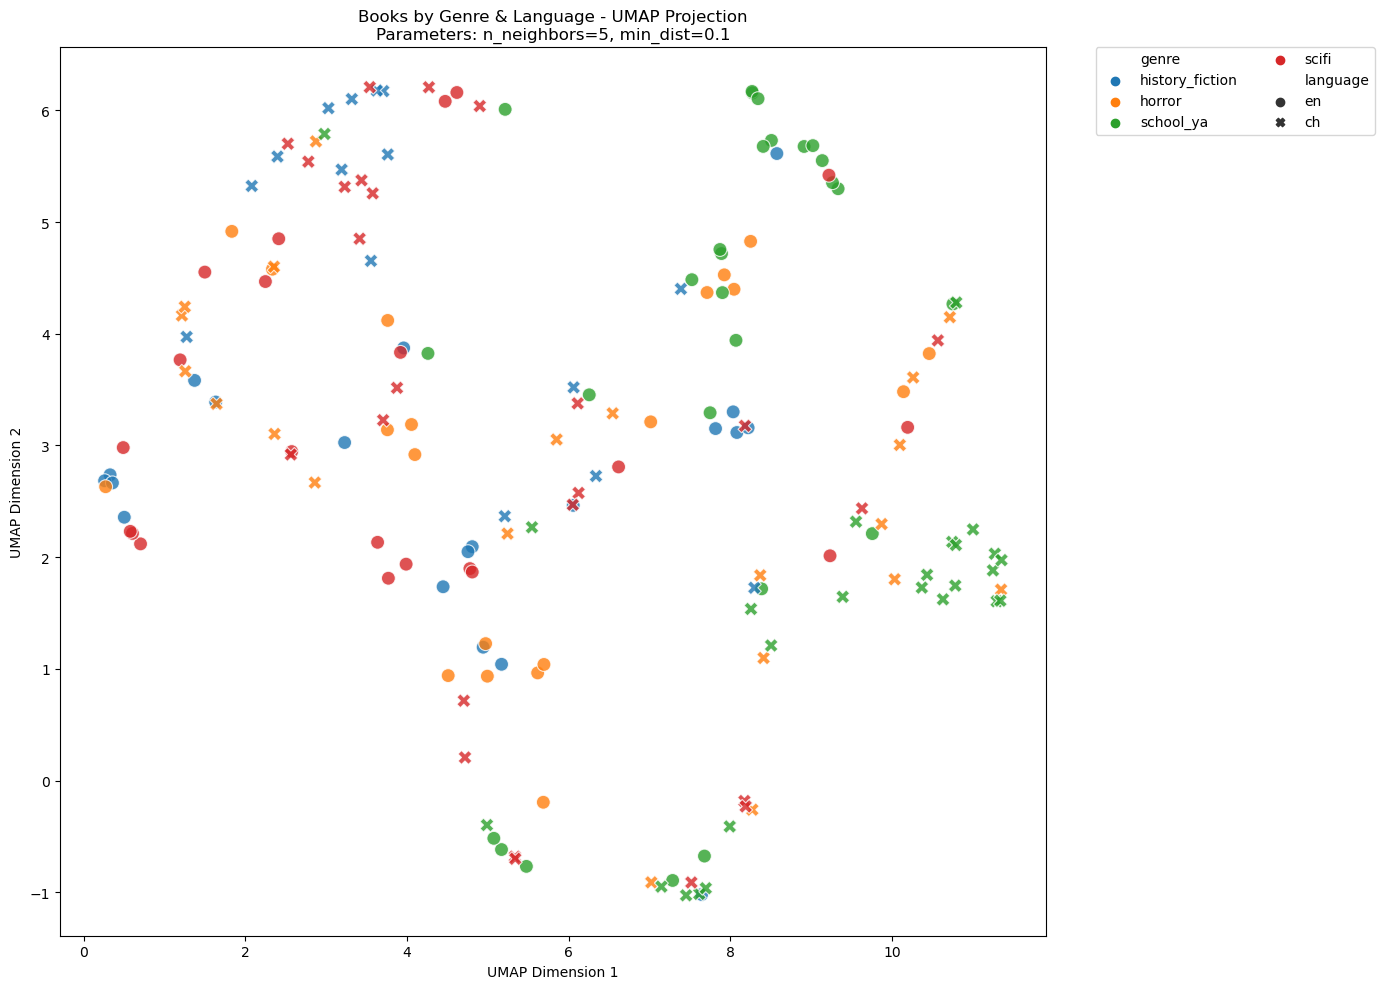

In [38]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_X)

# Choose the best looking visualization and apply it to your main dataframe
best_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,  # Adjust based on what looked best
    min_dist=0.1,    # Adjust based on what looked best
    random_state=42,
    metric='euclidean'
)

final_umap = best_reducer.fit_transform(X_scaled)
df["umap1"] = final_umap[:, 0]
df["umap2"] = final_umap[:, 1]

# Use categorical palette with maximum contrast
if len(df['genre'].unique()) <= 10:
    palette = "tab10"  # 10 distinct colors
elif len(df['genre'].unique()) <= 20:
    palette = "tab20"  # 20 distinct colors
else:
    palette = "gist_ncar"  # Many distinct color
# Final visualization with both color and style
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df,
    x="umap1", y="umap2",
    hue="genre",
    style="language",
    s=100,
    alpha=0.8,
    palette=palette
)

plt.title(f"Books by Genre & Language - UMAP Projection\n"
          f"Parameters: n_neighbors={best_reducer.n_neighbors}, min_dist={best_reducer.min_dist}")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Move legend outside
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    ncol=2 if len(df['language'].unique()) > 1 else 1
)

plt.tight_layout()
plt.show()

# Save final results
df.to_csv("results/analysis_with_umap_final.csv", index=False)


PEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)
             genre  n_en  n_zh  pearson_r  p_value  significant
1           horror    20    21     0.8064   0.1936        False
2        school_ya    27    25     0.2203   0.7797        False
3            scifi    21    25    -0.0504   0.9496        False
0  history_fiction    20    15    -0.2079   0.7921        False

Strong cross-language similarity (r > 0.7):
    genre  pearson_r  n_en  n_zh
1  horror   0.806356    20    21


Text(0.5, 1.0, 'How Similar Are English & Chinese Books in the Same Genre?\nHigher r = More similar stylistic profile')

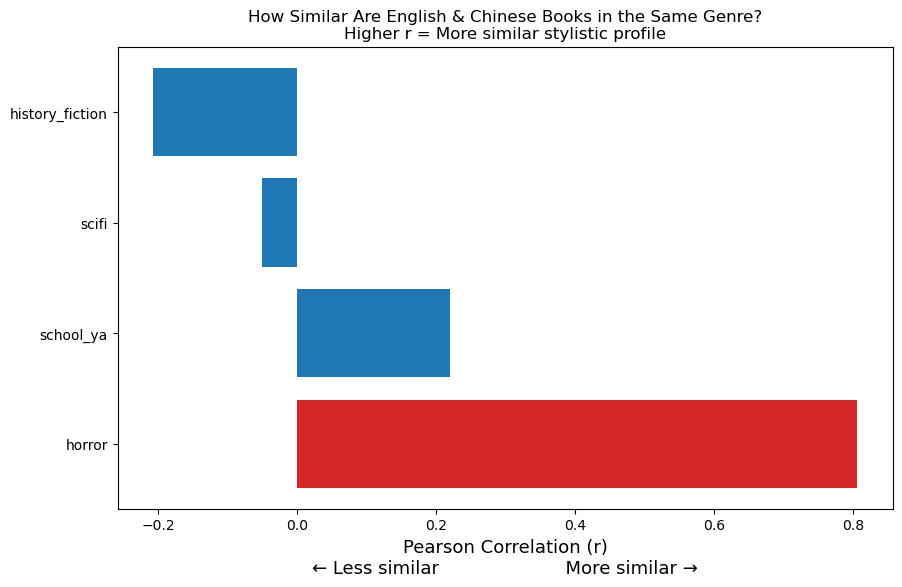

In [39]:
# ────────────────────────
# 1. Normalize the 3 features (same as before)
# ────────────────────────
features = ["pronoun_ratio", "info_density", "avg_sent_len","tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

X = df[features].values


# ────────────────────────
# 2. Pearson correlation: EN vs ZH within same genre
# ────────────────────────
results = []

for genre in df["genre"].unique():
    en_books = df[(df["genre"] == genre) & (df["language"] == "en")][features]
    zh_books = df[(df["genre"] == genre) & (df["language"] == "ch")][features]
    
    if len(en_books) < 2 or len(zh_books) < 2:
        print(f"Skipping {genre}: not enough books (EN={len(en_books)}, CH={len(zh_books)})")
        continue
    
    # Average stylistic profile per language
    en_mean = en_books.mean()
    zh_mean = zh_books.mean()
    
    # Pearson correlation between the two average vectors
    r, p = pearsonr(en_mean, zh_mean)
    
    results.append({
        "genre": genre,
        "n_en": len(en_books),
        "n_zh": len(zh_books),
        "pearson_r": r,
        "p_value": p,
        "significant": p < 0.05
    })

# Convert to DataFrame
corr_df = pd.DataFrame(results)
corr_df = corr_df.sort_values("pearson_r", ascending=False)

# ────────────────────────
# 3. Display results
# ────────────────────────
print("\nPEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)")
print("="*80)
print(corr_df.round(4))

# Highlight strong similarity
print("\nStrong cross-language similarity (r > 0.7):")
print(corr_df[corr_df["pearson_r"] > 0.7][["genre", "pearson_r", "n_en", "n_zh"]])

# ────────────────────────
# 4. Beautiful bar plot
# ────────────────────────
plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df["genre"], corr_df["pearson_r"], 
                color=np.where(abs(corr_df["pearson_r"]) > 0.7, "#d62728", 
                       np.where(abs(corr_df["pearson_r"]) > 0.4, "#ff7f0e", "#1f77b4")))

plt.xlabel("Pearson Correlation (r)\n← Less similar                      More similar →", fontsize=13)
plt.title("How Similar Are English & Chinese Books in the Same Genre?\n"
          "Higher r = More similar stylistic profile")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19916\3384999912.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19916\3384999912.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19916\3384999912.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19916\3384999912.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


<Figure size 1600x1200 with 0 Axes>

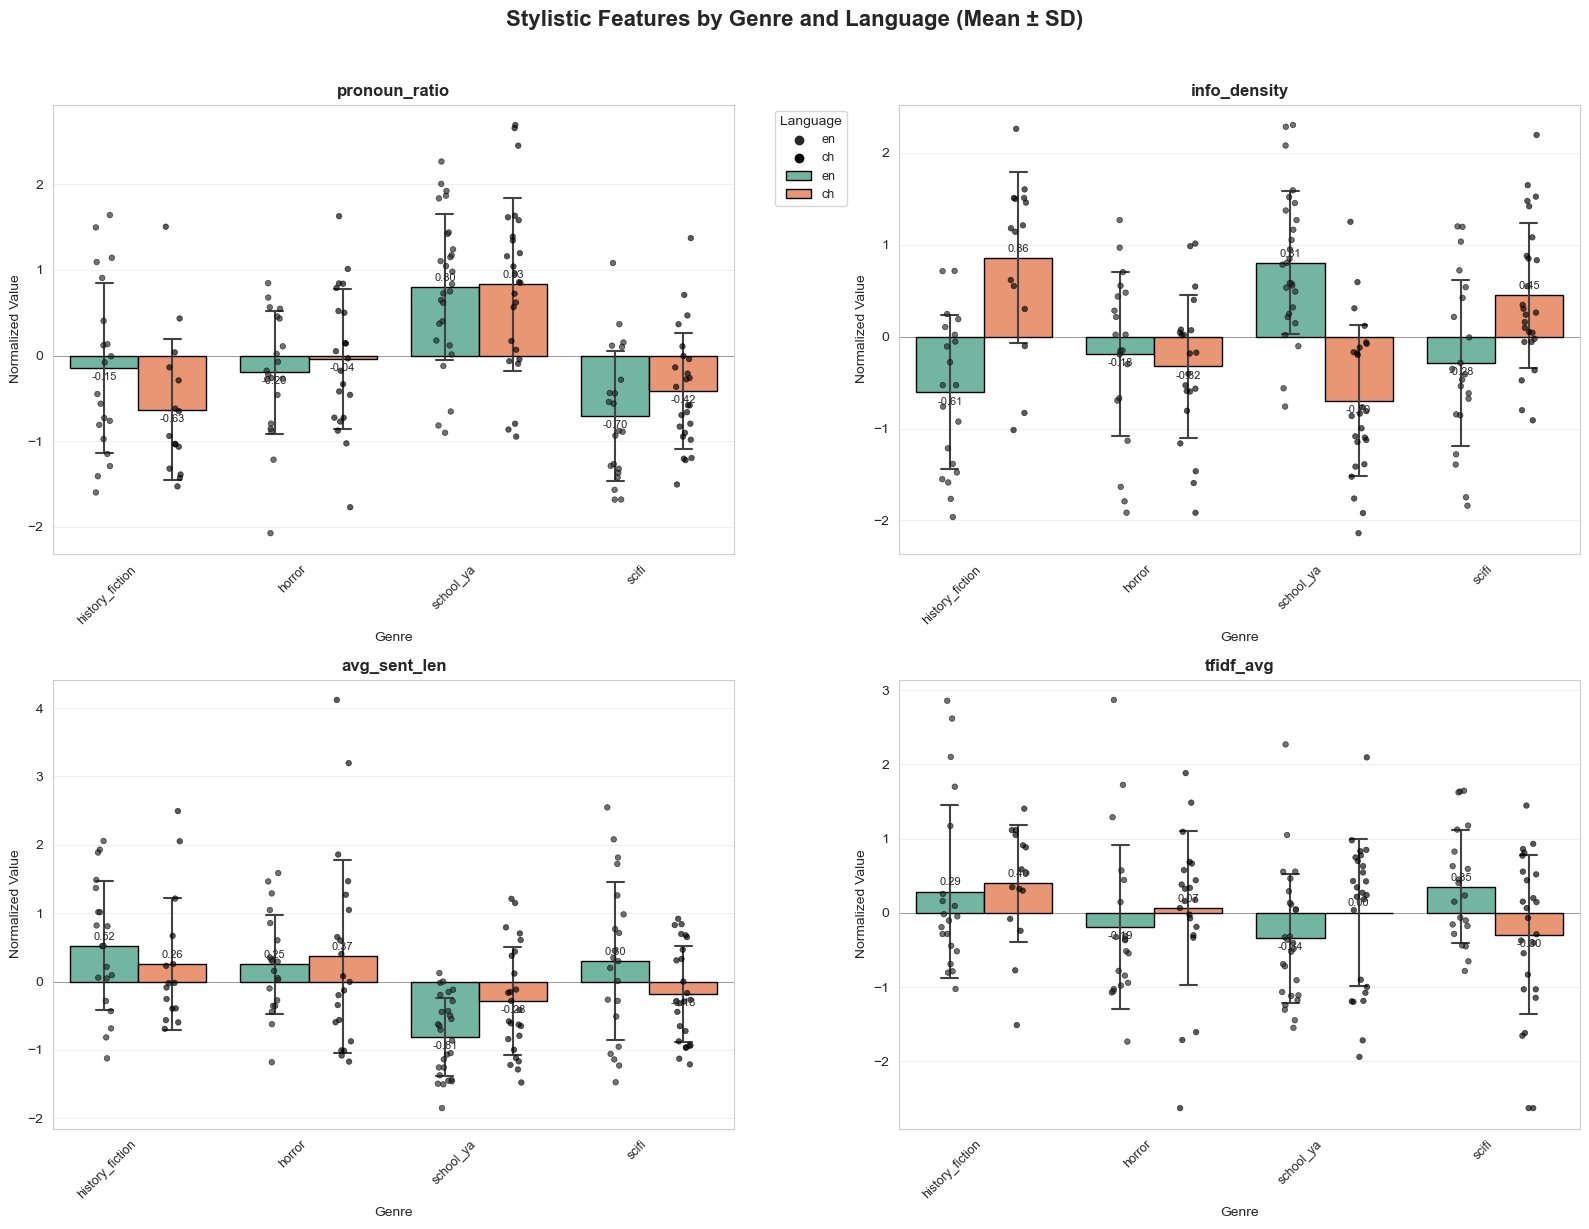

In [40]:
# Just use this simplified version:
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    norm_feature = f"{feature}"
    
    # Use seaborn barplot with ci='sd' for standard deviation
    sns.barplot(
        data=df,
        x="genre",
        y=norm_feature,
        hue="language",
        ax=ax,
        ci="sd",  # Standard deviation
        capsize=0.1,
        errwidth=1.5,
        palette="Set2",
        edgecolor='black',
        linewidth=1
    )
    # 2. ADD DOT PLOT — this is the magic!
    sns.stripplot(
        data=df,
        x="genre",
        y=norm_feature,
        hue="language",
        ax=ax,
        dodge=True,                  # separates points by hue (critical!)
        jitter=True,                 # spreads points horizontally
        size=4,                      # dot size
        alpha=0.65,                  # slightly transparent points
        edgecolor="black",
        linewidth=0.5,
        palette="dark:black"         # dark edges for visibility
    )
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    ax.set_title(f"{feature}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Genre", fontsize=10)
    ax.set_ylabel("Normalized Value", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    if idx == 0:
        ax.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    else:
        ax.legend().remove()

fig.suptitle("Stylistic Features by Genre and Language (Mean ± SD)", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [5]:
#investigate if the differences of pronoun ratio are significant using t-test
mean,std = df["pronoun_ratio"].mean(),df["pronoun_ratio"].std()
n = len(df)
se = std/np.sqrt(n)

In [11]:
school_ya_mean = df[df["genre"]=="ya_school_life"]["pronoun_ratio"].mean()

In [13]:
freedom_degree = len(df)-1

In [12]:
school_ya_mean

1.008466940168243

In [14]:
t_score = (school_ya_mean - mean) / se

In [15]:
p = t.sf(t_score, freedom_degree)
p

5.981039648960641e-12

In [52]:
df

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath,tfidf_avg,umap1,umap2
0,-1.600466,-0.924076,0.044852,en,129408,All the Light We Cannot See - Anthony Doerr.txt,history_fiction,../data/english\history_fiction\All the Light ...,-0.443909,4.447665,1.734893
1,-0.810758,-1.550994,1.928943,en,127227,Atonement (Ian McEwan) (Z-Library).txt,history_fiction,../data/english\history_fiction\Atonement (Ian...,2.099346,0.327436,2.737273
2,1.141841,0.191181,0.517778,en,244262,Boleyn 1 The Other Boleyn Girl (Philippa Grego...,history_fiction,../data/english\history_fiction\Boleyn 1 The O...,-0.019748,8.036662,3.301062
3,1.092357,-0.105854,0.214558,en,141904,Bring Up the Bodies - Hilary Mantel.txt,history_fiction,../data/english\history_fiction\Bring Up the B...,0.092094,8.082609,3.116106
4,-0.449635,-1.384388,0.523172,en,124339,Emperor the Gates of Rome (Conn Iggulden) (Z-L...,history_fiction,../data/english\history_fiction\Emperor the Ga...,-0.788419,5.171082,1.040581
...,...,...,...,...,...,...,...,...,...,...,...
169,-0.005175,0.097381,0.695548,ch,96657,球状闪电（没有《球状闪电》，就没有后来的《三体》《三体》前传，刘慈欣三大长篇作品之一！《三体...,scifi,../data/chinese\scifi\球状闪电（没有《球状闪电》，就没有后来的《三体》...,-0.373612,3.705706,3.226813
170,-0.262352,0.159386,-0.292076,ch,86095,类人 (王晋康) (Z-Library).txt,scifi,../data/chinese\scifi\类人 (王晋康) (Z-Library).txt,-2.629887,8.191387,-0.232184
171,-0.696098,0.305172,-0.937367,ch,160594,红色海洋 (韩松 [韩松]) (Z-Library).txt,scifi,../data/chinese\scifi\红色海洋 (韩松 [韩松]) (Z-Librar...,0.808142,6.052497,2.469341
172,-0.903769,2.196148,0.309406,ch,87601,荒潮 (陈楸帆) (Z-Library).txt,scifi,../data/chinese\scifi\荒潮 (陈楸帆) (Z-Library).txt,-0.832520,3.414625,4.851603


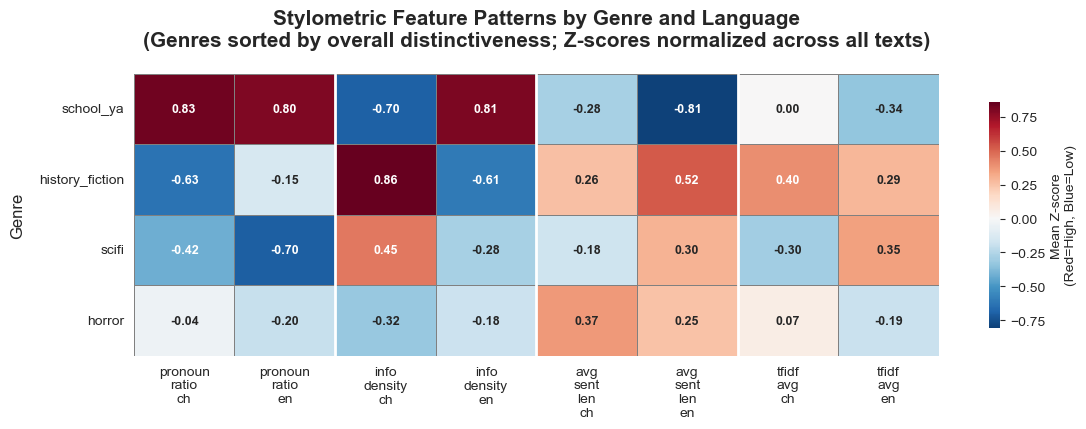

In [57]:
# Ensure data is prepared
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

# Normalize features: Compute z-scores across the entire dataset
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Compute mean z-scores per genre and language
mean_df = (
    df.groupby(["genre", "language"])[features]
      .mean()
      .reset_index()
)

# Compute overall distinctiveness for each genre: average absolute mean z-score across all features and languages
genre_distinctiveness = (
    mean_df.groupby("genre")[features]
           .apply(lambda x: np.abs(x).mean().mean())
)
sorted_genres = genre_distinctiveness.sort_values(ascending=False).index.tolist()

# Sort genres accordingly
mean_df["genre"] = pd.Categorical(mean_df["genre"], categories=sorted_genres, ordered=True)
mean_df = mean_df.sort_values("genre").reset_index(drop=True)

# Get sorted languages
languages = sorted(df["language"].unique())

# Prepare data for a single large heatmap
# Multi-index: rows = genre, columns = (feature, language)
pivot_data = mean_df.set_index(["genre", "language"])[features].unstack("language")

# Flatten columns to "feature_language"
pivot_data.columns = [f"{feat}_{lang}" for feat, lang in pivot_data.columns]

# Order columns: group by feature, then by language
ordered_columns = [f"{feat}_{lang}" for feat in features for lang in languages]
pivot_data = pivot_data[ordered_columns]

# Create detailed y-tick labels (you can customize further if needed)
y_tick_labels = sorted_genres  # Already sorted

# Plot the single heatmap
plt.figure(figsize=(len(features) * len(languages) * 1.2 + 2, len(sorted_genres) * 0.6 + 2))
ax = sns.heatmap(pivot_data,
                 annot=True,
                 fmt=".2f",
                 cmap="RdBu_r",
                 center=0,
                 cbar_kws={'label': 'Mean Z-score\n(Red=High, Blue=Low)', 'shrink': 0.8},
                 linewidths=0.5,
                 linecolor='gray',
                 yticklabels=y_tick_labels,
                 annot_kws={'size': 9, 'weight': 'bold'})

# Improve x-axis labels: multi-line "Feature\nLanguage"
xtick_labels = [label.replace("_", "\n") for label in ordered_columns]
ax.set_xticklabels(xtick_labels, rotation=0, ha='center', fontsize=10)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax.set_ylabel("Genre", fontsize=12, labelpad=10)
ax.set_xlabel("")  # No need for xlabel as ticks are self-explanatory

plt.title("Stylometric Feature Patterns by Genre and Language\n"
          "(Genres sorted by overall distinctiveness; Z-scores normalized across all texts)",
          fontsize=15, fontweight='bold', pad=20)

# Optional: Add vertical lines to separate feature groups
for i in range(len(features) - 1):
    pos = (i + 1) * len(languages)
    ax.axvline(pos, color='white', linewidth=2)

plt.tight_layout()
plt.show()

In [3]:
df = pd.read_csv('results/df.csv')

In [4]:
df

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath,tfidf_avg,pca1,pca2,pronoun_ratio_norm,info_density_norm,avg_sent_len_norm,tfidf_avg_norm,umap1,umap2
0,-0.130340,0.107400,-0.547247,en,149359,The Nightingale - Kristin Hannah.txt,history_fiction,../data/english/history_fiction/The Nightingal...,-1.062238,-0.683289,0.042503,-0.130340,0.107400,-0.547247,-1.062238,5.453007,13.856578
1,1.472748,0.612350,-0.693430,en,101501,The Song of Achilles - Madeline Miller.txt,history_fiction,../data/english/history_fiction/The Song of Ac...,-0.682683,-1.675061,-0.479731,1.472748,0.612350,-0.693430,-0.682683,6.244404,15.052033
2,-1.308206,-0.456095,-0.100420,en,320064,Fall of Giants - Ken Follett.txt,history_fiction,../data/english/history_fiction/Fall of Giants...,0.418602,0.897780,0.527063,-1.308206,-0.456095,-0.100420,0.418602,11.059678,10.971647
3,0.691650,-0.134843,0.320977,en,217990,Wolf Hall - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Wolf Hall - Hi...,0.041322,-0.061458,-0.547175,0.691650,-0.134843,0.320977,0.041322,6.138467,13.493646
4,0.889461,-0.272154,0.456338,en,141904,Bring Up the Bodies - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Bring Up the B...,-0.073947,-0.049485,-0.802725,0.889461,-0.272154,0.456338,-0.073947,5.988163,13.242958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.695187,-1.511967,-0.554985,ch,131819,1. 最好的我们 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/1. 最好的我们 (八月长安 ...,0.262656,-0.575043,-2.095409,1.695187,-1.511967,-0.554985,0.262656,7.595441,12.701002
63,0.534087,-0.033544,-0.736333,ch,57412,5. 云边有个小卖部（张嘉佳全新力作！写给我们所遇见的悲伤和希望，和路上从未断绝的一缕光！）...,ya_school_life,../data/chinese/ya_school_life/5. 云边有个小卖部（张嘉佳全...,-1.101471,-1.108129,-0.460031,0.534087,-0.033544,-0.736333,-1.101471,5.253937,13.987090
64,1.161043,-1.405816,-0.491059,ch,210332,10. 暗恋·橘生淮南 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/10. 暗恋·橘生淮南 (八月...,0.204537,-0.319577,-1.703166,1.161043,-1.405816,-0.491059,0.204537,7.363704,12.635376
65,1.303868,-0.423448,-1.042399,ch,520852,8. 玖月晞亲爱的系列（套装2册） (玖月晞 [jiuyuexi]) (Z-Library)...,ya_school_life,../data/chinese/ya_school_life/8. 玖月晞亲爱的系列（套装2...,1.722720,-0.689701,-0.754416,1.303868,-0.423448,-1.042399,1.722720,8.423312,13.305703


In [ ]:
df.to_csv('results/df.csv', index=False) 